# Proyecto Final

***Equipo 07***

- Aide Jazmín González Cruz
- Elena Villalobos Nolasco
- Carolina Acosta Tovany

#### Instrucciones

El proyecto/examen final consistirá en:

La implementación del algoritmo de filtrado colaborativo utilizando la metodología vista en clase (uso de otra metodología no se calificará).

Todos los algoritmos de aprendizaje de máquina que se utilicen deberán haber sido creados por ustedes. Sólo podrán utilizar Transformers y funciones de apoyo de scikit-learn (para realizar la división de los datos en entrenamiento y prueba, o el procedimiento de validación cruzada, etc.) mas ningún estimator (regresión logística, máquina de vectores de soporte, k medias, etc.). 

Se deberá explicar como se obtuvo la k con la que se generó el resultado final.

Se utilizarán los archivos con el conjunto pequeño de calificaciones y películas ubicado en la siguiente https://www.kaggle.com/rounakbanik/the-movies-dataset:

- **links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

- **ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

Con el fin de mejorar la calificación (opcional, puntos extra), se podrán utilizar los algoritmos desarrollado en las tareas del curso y los datos relevantes (los que hacen match con los datos anteriores) contenidos en los archivos:

- **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- **keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- **credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

La métrica con la que se determinará el desempeño del algoritmo es el NDCG 

(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

Una vez obtenida la matriz de calificaciones, el programa deberá ser capaz de regresar las 5 mejores recomendaciones del o de los usuarios que se consulten.

El proyecto se entregará en un Jupyter notebook. El readme file debe contener las instrucciones para que se ejecute el código. Deben cerciorarse que siguiendo esas instrucciones el programa corre sin errores. 

Se deberá subir a la carpeta proyecto_final/equipo_xx en el repositorio GitHub antes de las 7:00 am del día del examen final (14 de diciembre de 2020).    

In [1]:
# Importación de paqueterías necesarias
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Importación de paqueterías creadas por nosotras
from sis_recom import load_data 
from sis_recom import create_train_test, fun_ECM

La función objetivo:
    
$$J(X) = \frac{1}{2} \displaystyle\sum_{(a,i)\in\mathbb{D}} \left(Y_{ai}-\left [ UV^T \right ]_{ai} \right)^2 + \frac{\lambda}{2} \displaystyle\sum_{a=1}^n \displaystyle\sum_{j=1}^k U_{aj}^2 + \frac{\lambda}{2} \displaystyle\sum_{i=1}^m \displaystyle\sum_{j=1}^k V_{ij}^2$$

#### Ya derivadas e igualadas a cero dependiendo de los usuarios e items:

$$x_u^T = r_uY\left(Y^TY+\lambda_xI^{-1}\right)$$

$$y_i^T = r_iX\left(X^TX+\lambda_yI^{-1}\right)$$

In [62]:
# Cargamos datos ya limpios
ratings, bases_nombres_id, arr_movies = load_data()

In [4]:
ratings.head()

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
n_users, n_items = ratings.shape

In [6]:
n_users, n_items

(671, 9125)

In [7]:
# Separando datos en train y test
train, test = create_train_test(np.array(ratings))

In [8]:
train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [9]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [73]:
class DampedUserMovieBaselineModel():
    """Baseline model that of the form mu + b_u + b_i,
    where mu is the overall average, b_u is a damped user
    average rating residual, and b_i is a damped item (movie)
    average rating residual. See eqn 2.1 of
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf
    Parameters
    ----------
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be positive.
    Attributes
    ----------
    mu : float
        Average rating over all training samples
    b_u : pandas Series, shape = [n_users]
        User residuals
    b_i : pandas Series, shape = [n_movies]
        Movie residuals
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be >= 0.
    """
    def __init__(self, damping_factor=0):
        self.damping_factor = damping_factor

    def fit(self, X):
        """Fit training data.
        Parameters
        ----------
        X : DataFrame, shape = [n_samples, >=3]
            User, movie, rating dataFrame. Columns beyond 3 are ignored
        Returns
        -------
        self : object
        """
        X = X.iloc[:, :3].copy()
        X.columns = ['user', 'item', 'rating']
        self.mu = np.mean(X['rating'])
        user_counts = X['user'].value_counts()
        movie_counts = X['item'].value_counts()
        b_u = (
            X[['user', 'rating']]
            .groupby('user')['rating']
            .sum()
            .subtract(user_counts * self.mu)
            .divide(user_counts + self.damping_factor)
            .rename('b_u')
        )
        X = X.join(b_u, on='user')
        X['item_residual'] = X['rating'] - X['b_u'] - self.mu
        b_i = (
            X[['item', 'item_residual']]
            .groupby('item')['item_residual']
            .sum()
            .divide(movie_counts + self.damping_factor)
            .rename('b_i')
        )
        self.b_u = b_u
        self.b_i = b_i
        return self

    def predict(self, X):
        """Return rating predictions
        Parameters
        ----------
        X : DataFrame, shape = (n_ratings, 2)
            User, item dataframe
        Returns
        -------
        y_pred : numpy array, shape = (n_ratings,)
            Array of n_samples rating predictions
        """
        X = X.iloc[:, :2].copy()
        X.columns = ['user', 'item']
        X = X.join(self.b_u, on='user').fillna(0)
        X = X.join(self.b_i, on='item').fillna(0)
        return (self.mu + X['b_u'] + X['b_i']).values


In [77]:
def mse_f(actual, predicted):
    sum_error = 0.0
    # loop over all values
    for i in range(len(actual)):
        # the error is the sum of (actual - prediction)^2
        prediction_error =  actual[i] - predicted[i]
        sum_error += (prediction_error ** 2)
    # now normalize
    mean_error = sum_error / float(len(actual))
    return (mean_error)

def get_rating_matrix(X):
    """Function to generate a ratings matrx and mappings for
    the user and item ids to the row and column indices

    Parameters
    ----------
    X : pandas.DataFrame, shape=(n_ratings,>=3)
        First 3 columns must be in order of user, item, rating.

    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    """
    user_col, item_col, rating_col = X.columns[:3]
    rating = X[rating_col]
    user_map = pd.Series(
        index=np.unique(X[user_col]),
        data=np.arange(X[user_col].nunique()),
        name='user_map',
    )
    item_map = pd.Series(
        index=np.unique(X[item_col]),
        data=np.arange(X[item_col].nunique()),
        name='columns_map',
    )
    user_inds = X[user_col].map(user_map)
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table(
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map

class Matrix_Factorization:
    """Recommender based on Alternating Least Squares algorithm.
    
    Parameters
    ----------
    k : int, default=5
        Number of latent features
    lmbda : float, default=0.1
        Regularization parameter
    max_epochs : int, default=15
        Max number of iterations to run
    baseline_algo : object
        Object with fit(X) and 
    """
    def __init__(self, k=5, lmbda=0.1, max_epochs=15, baseline_algo=None, 
                 #error_metric='mae', 
                 verbose=True):
        # Force integer in case it comes in as float
        self.k = int(np.round(k))
        self.lmbda = lmbda
        self.max_epochs = max_epochs
        self.baseline_algo = baseline_algo
        #self.error_metric = error_metric
        self.verbose = verbose

        self.U = None
        self.I = None
        self.initialized = False

    def _calc_train_error(self, U, I, R, R_selector=None):#, error_metric='mae'
        if R_selector is None:
            R_selector = (R > 0)
        R_hat = np.dot(U.T, I)
        #if error_metric == 'mae':
        error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector)
        #else:
        #    raise ValueError("{} is an unsupported error metric".format(metric))
        
        #error = mse_f(R,R_hat)
        
        return error

    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
        else:
            self.baseline_algo.fit(X)
        
        #print(X)
        self.R, self.user_map, self.item_map = get_rating_matrix(X)
        
        n_users, n_items = self.R.shape
        self.U = 3 * np.random.rand(self.k, n_users)
        self.I = 3 * np.random.rand(self.k, n_items)
        self.I[0, :] = self.R[self.R != 0].mean(axis=0) # Avg. rating for each movie
        self.E = np.eye(self.k) # (k x k)-dimensional idendity matrix
        self.epoch = 0
        self.train_errors = []
        self.initialized = True

    def fit(self, X, n_epochs=None):
        """Fit model to training data X. If at least one iteration has already been run,
        then the model will continue from its most recent state.

        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs

        Returns
        -------
        self
            This allows chaining like `ALSRecommender().fit(X_train).predict(X_test)`
        """
        # Allow continuation from previous state if n_epochs is given. Otherwise start from scratch.
        if n_epochs is None:
            self.initialized = False
        if not self.initialized:
            self._fit_init(X)

        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0

        n_users, n_items = self.R.shape

        # Run n_epochs iterations
        for i_epoch in range(n_epochs):
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # Fix I and estimate U
            for i, Ri in enumerate(self.R):
                nui = np.count_nonzero(Ri) # Number of items user i has rated
                if (nui == 0): nui = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ii
                Ri_nonzero_selector = np.nonzero(Ri)[0]
                # Select subset of I associated with movies reviewed by user i
                I_Ri = self.I[:, Ri_nonzero_selector]
                # Select subset of row R_i associated with movies reviewed by user i
                Ri_nonzero = self.R[i, Ri_nonzero_selector]
                Ai = np.dot(I_Ri, I_Ri.T) + self.lmbda * nui * self.E
                Vi = np.dot(I_Ri, Ri_nonzero.T)
                self.U[:, i] = np.linalg.solve(Ai, Vi)
            # Fix U and estimate I
            for j, Rj in enumerate(self.R.T):
                nmj = np.count_nonzero(Rj) # Number of users that rated item j
                if (nmj == 0): nmj = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ij
                Rj_nonzero_selector = np.nonzero(Rj)[0]
                # Select subset of P associated with users who reviewed movie j
                U_Rj = self.U[:, Rj_nonzero_selector]
                # Select subset of column R_j associated with users who reviewed movie j
                Rj_nonzero = self.R[Rj_nonzero_selector, j]
                Aj = np.dot(U_Rj, U_Rj.T) + self.lmbda * nmj * self.E
                Vj = np.dot(U_Rj, Rj_nonzero)
                self.I[:, j] = np.linalg.solve(Aj, Vj)
            error = self._calc_train_error(self.U, self.I, self.R)
            self.train_errors.append(error)
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    def predict(self, X):
        """Generate predictions for user/item pairs
        
        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe
            
        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            Array of rating predictions for each user/item pair
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        
        rating_pred = np.array([
            np.sum(self.U[:, u_ind] * self.I[:, i_ind])
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)
        min_rating = np.min(self.R[np.nonzero(self.R)])
        max_rating = np.max(self.R)
        X.loc[X['rating'] < min_rating, 'rating'] = min_rating
        X.loc[X['rating'] > max_rating, 'rating'] = max_rating
        return X['rating'].values

In [80]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred), axis=0)


#from datetime import datetime
#%%time
n_splits = 5
max_epochs = 50

ratings = ratings_small[["userId","movieId", "rating"]]

kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

train_errs = np.zeros((n_splits, max_epochs))
test_errs = np.zeros((n_splits, max_epochs))

for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings)):
    
    print("i_fold={}".format(i_fold))
    
    train_df, test_df = ratings.iloc[train_inds], ratings.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    
    rec = Matrix_Factorization(k=20, baseline_algo=baseline_algo, 
                               verbose=False, max_epochs=max_epochs)
    
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        preds = rec.predict(test_df[['userId', 'movieId']])
        #test_err = mean_absolute_error(preds, test_df['rating'])
        test_err = mae(preds, test_df['rating'])
        ##test_err = mse_f(preds, test_df['rating'])
        # print("[Epoch {}/{}] test MAE: {}".format(i_epoch, max_epochs, test_err))
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors)

print(f"There are {len(rec.user_map)} users and {len(rec.item_map)} items")

i_fold=0
        userId  movieId  rating
0            1       31     2.5
1            1     1029     3.0
2            1     1061     3.0
4            1     1172     4.0
5            1     1263     2.0
...        ...      ...     ...
99998      671     6212     2.5
99999      671     6268     2.5
100000     671     6269     4.0
100001     671     6365     4.0
100002     671     6385     2.5

[80003 rows x 3 columns]
i_fold=1
        userId  movieId  rating
0            1       31     2.5
2            1     1061     3.0
3            1     1129     2.0
4            1     1172     4.0
5            1     1263     2.0
...        ...      ...     ...
99998      671     6212     2.5
99999      671     6268     2.5
100000     671     6269     4.0
100001     671     6365     4.0
100003     671     6565     3.5

[80003 rows x 3 columns]
i_fold=2
        userId  movieId  rating
1            1     1029     3.0
2            1     1061     3.0
3            1     1129     2.0
6            1     1287  

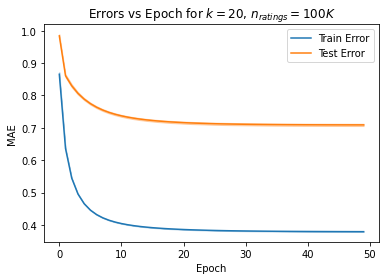

In [81]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.fill_between(np.arange(max_epochs), train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(r'Errors vs Epoch for $k=20$, $n_{ratings}=100K$')
plt.show()

In [84]:
n_splits = 5
max_epochs = 15
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [1, 2, 5, 10, 20, 50, 100]
small_df = ratings.iloc[:100000]
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = Matrix_Factorization(k=k, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=1,        userId  movieId  rating
0           1       31     2.5
1           1     1029     3.0
2           1     1061     3.0
4           1     1172     4.0
5           1     1263     2.0
...       ...      ...     ...
99995     671     5989     4.0
99996     671     5991     4.5
99997     671     5995     4.0
99998     671     6212     2.5
99999     671     6268     2.5

[80000 rows x 3 columns]
k=2,        userId  movieId  rating
0           1       31     2.5
1           1     1029     3.0
2           1     1061     3.0
4           1     1172     4.0
5           1     1263     2.0
...       ...      ...     ...
99995     671     5989     4.0
99996     671     5991     4.5
99997     671     5995     4.0
99998     671     6212     2.5
99999     671     6268     2.5

[80000 rows x 3 columns]
k=5,        userId  movieId  rating
0           1       31     2.5
1           1     1029     3.0
2           1     1061     3.0
4           1     1172     4.0
5           1     1263  


i_fold=3: k=1,        userId  movieId  rating
0           1       31     2.5
1           1     1029     3.0
2           1     1061     3.0
3           1     1129     2.0
4           1     1172     4.0
...       ...      ...     ...
99992     671     5816     4.0
99994     671     5952     5.0
99995     671     5989     4.0
99998     671     6212     2.5
99999     671     6268     2.5

[80000 rows x 3 columns]
k=2,        userId  movieId  rating
0           1       31     2.5
1           1     1029     3.0
2           1     1061     3.0
3           1     1129     2.0
4           1     1172     4.0
...       ...      ...     ...
99992     671     5816     4.0
99994     671     5952     5.0
99995     671     5989     4.0
99998     671     6212     2.5
99999     671     6268     2.5

[80000 rows x 3 columns]
k=5,        userId  movieId  rating
0           1       31     2.5
1           1     1029     3.0
2           1     1061     3.0
3           1     1129     2.0
4           1     1172 

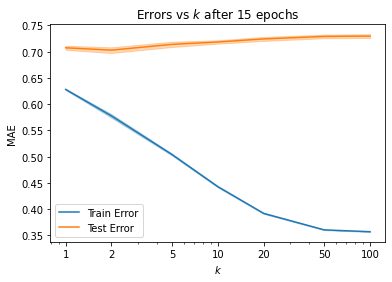

In [85]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, train_avg, label='Train Error')
plt.fill_between(k_list, train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel('MAE')
plt.title(r'Errors vs $k$ after {} epochs'.format(max_epochs))
plt.show()

In [11]:
als = Matrix_Factorization(n_iters = 15, k = 36, _lambda = 0.01)
als.fit(train, test)

<span style="color:red">Agregado legend</span>

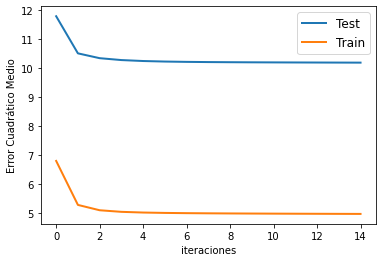

In [12]:
plt.plot(als.test_ecm_record, label = 'Test', linewidth = 2)
plt.plot(als.train_ecm_record, label = 'Train', linewidth = 2)
plt.xlabel('iteraciones')
plt.legend(bbox_to_anchor=(1, 1), fontsize = 12)#Agregado
plt.ylabel('Error Cuadrático Medio')
plt.show()

Observamos que con muy pocas iteraciones el ECM baja, por lo que en las siguientes evaluaciones utilizaremos 15 iteraciones.

### Cross Validation

Ahora realizamos el método de Cross Validation para obtener la mejor k.

In [13]:
n_folds = 5

In [14]:
K_list = [10,71,171,271,371,471,571,671]

In [15]:
#K_list = []
#for i in range(1, train.shape[0], 10):
#for i in range(1, train.shape[0], 100):
#    K_list.append(i)

In [16]:
K_list

[10, 71, 171, 271, 371, 471, 571, 671]

In [17]:
df_k = pd.DataFrame(0.0, index=range(1), columns=K_list)
data = train

In [18]:
data.shape

(671, 9125)

In [19]:
# Dividimos los datos en chunk de igual tamaño de forma vertical
chunks = np.hsplit(data, n_folds)
for k in K_list:
    error = 0.0
    for i in range(1, int(n_folds)):

        # El chunk i será nuestro bloque de datos de prueba
        test_data = chunks[i]

        # Entrenamos con todos los otros datos menos con el chunk[i]
        train_data = chunks.copy()
        train_data.pop(i)
        train_data = np.concatenate(train_data)
        
        als = Matrix_Factorization(n_iters = 15, k = k, _lambda = 0.01)
        als.fit(train_data, test_data)
        error += als.train_ecm_record[1]
    error /= n_folds

    df_k[k][0] = error

#df_k.idxmin(axis=1)[0]
df_k

,10,71,171,271,371,471,571,671
0,6.082464,3.712859,2.046674,1.179058,0.683294,0.394187,0.224858,0.125774


In [20]:
K_list=np.array(K_list)

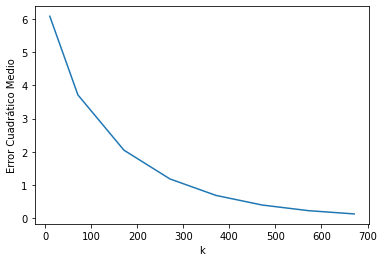

In [21]:
plt.plot(K_list,df_k.iloc[0])
plt.xlabel('k')
plt.ylabel('Error Cuadrático Medio')
plt.show()
plt.show()

Una vez elegido el modelo realizaremos la validación: 

In [22]:
als = Matrix_Factorization(n_iters = 15, k = 200, _lambda = 0.01)
als.fit(train, test)

In [23]:
# Esta es la matriz completa para poder hacer recomendaciones
MCompleta = als.predict()
MCompleta = pd.DataFrame(MCompleta, 
                         columns=ratings.columns, 
                         index=ratings.index)

In [24]:
def recomendaciones_id(Y, MCompleta, array_movies, bases_nombres_id, user, top=5):
    """
    Regresa id de las peliculas reomendadas dado un usuario
    Param: Recibe matriz con Nan, id del usurario y el top por default 5
    Return: Arreglo de ids de las películas sugeridas
    """
    
    # ------------------------------------ Para nuevas recomendaciones------------------------------
    # Se multiplica boleano con Y para poner en cero los ratings dados por el usuario
    nvos = []
    # Agregando índice
    for i in range (len(MCompleta)):
        # Se concatena el indice de la pélicula
        nvos.append([array_movies[i],MCompleta[i]*(~Y[i].any())])
    
    # nvos es un arreglo se pasa a dataframe para mejor manejabilidad
    nvos = pd.DataFrame(nvos)
    # se colocan nombres a las columnas
    nvos.columns = ['id_movie','rating_recom']
    # se ordenan de forma descendente
    nvos = nvos.sort_values(by=['rating_recom'], ascending=False)
    # Borrando 0
    nvos = nvos[(nvos[['rating_recom']] != 0).all(axis=1)]
    # Obteniendo el top
    recomendaciones = nvos['id_movie'].head(5).to_numpy()
    
    # ------------------------------------ Para recomendaciones incluyendo las existentes ----------
    # Incluyendo los datos calificados
    todos = []
    # Agregando índice
    for i in range (len(MCompleta)):
        # Se concatena el indice de la pélicula
        todos.append([array_movies[i], MCompleta[i]])
    # todos es un arreglo se pasa a dataframe para mejor manejabilidad
    todos = pd.DataFrame(todos)
    # se colocan nombres a las columnas
    todos.columns = ['id_movie','rating_recom']
    # se ordenan de forma descendente
    todos = todos.sort_values(by=['rating_recom'], ascending=False)
    # Obteniendo el top
    recomendaciones_t = todos['id_movie'].head(5).to_numpy()  
    
    # Por si se quiere imprimir desde aqui las recomendaciones
    print("Estás son las nuevas películas que te recomendamos usuario no. ", user)
    print(bases_nombres_id[bases_nombres_id['movieId'].isin(recomendaciones)][["movieId", "title"]])
    
    print("Estás películas te pueden interesar usuario no. ", user)
    print(bases_nombres_id[bases_nombres_id['movieId'].isin(recomendaciones_t)][["movieId", "title"]])
    
    return recomendaciones, recomendaciones_t

In [25]:
id_user = 1

In [26]:
rec_nvas, rec_todas = recomendaciones_id(np.array(ratings)[id_user-1], np.array(MCompleta)[id_user-1], 
                                         arr_movies, bases_nombres_id, id_user)

Estás son las nuevas películas que te recomendamos usuario no.  1
      movieId                            title
101      1374  Star Trek II: The Wrath of Khan
168      1221           The Godfather: Part II
489      1244                        Manhattan
2184     1249                  La Femme Nikita
4265      246                      Hoop Dreams
Estás películas te pueden interesar usuario no.  1
      movieId            title
463      1287          Ben-Hur
564      1061         Sleepers
1682     1339          Dracula
3291     1172  Cinema Paradiso
3588     1263  The Deer Hunter


In [27]:
# Películas que no ha visto
print("Estás son las nuevas películas que te recomendamos usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_nvas)][["movieId", "title"]]

Estás son las nuevas películas que te recomendamos usuario no.  1


,movieId,title
101,1374,Star Trek II: The Wrath of Khan
168,1221,The Godfather: Part II
489,1244,Manhattan
2184,1249,La Femme Nikita
4265,246,Hoop Dreams


In [28]:
# Películas que ya vio
print("Estás películas te pueden interesar usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_todas)][["movieId", "title"]]

Estás películas te pueden interesar usuario no.  1


,movieId,title
463,1287,Ben-Hur
564,1061,Sleepers
1682,1339,Dracula
3291,1172,Cinema Paradiso
3588,1263,The Deer Hunter


In [64]:
ratings_small = pd.read_csv('ratings_small.csv')
ratings_small

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [30]:
def desempenio_NDCG(ratings, user):
    """
    Evaluar el desempeño para un usuario
    :param user: usuario a evaluar
    :return ndcg: normalized discounted cumulative gain
    """
    
    rating_1 = ratings.loc[user]
    rating_user = rating_1[rating_1!=0]
    suma_dcg = 0
    suma_idcg = 0
    for i in range(0, len(rating_user)):
        suma_dcg += rating_user[i] / np.log2(i+1 + 1)
        suma_idcg += (pow(2,rating_user[i]) - 1) / np.log2(i+1 + 1)

    ndcg = round(suma_dcg / suma_idcg,2)
    
    return ndcg

In [31]:
# Probemos para el usuario 1
desempenio_NDCG(ratings, id_user)

0.43

In [32]:
# Obtengamos  el desempeño para todos los usuarios
def obtain_ndcg_all_users(ratings):
    ndcg = {}
    
    for user in ratings.index:
        ndcg.update({user:desempenio_NDCG(ratings, user)})
        #ndcg[user] desempenio_NDCG(Y_0, id_user)
    return ndcg

In [33]:
ndcg = obtain_ndcg_all_users(MCompleta)

In [46]:
ndcg_Y_0 = obtain_ndcg_all_users(ratings)
ndcg_Y_0

{1: 0.43,
 2: 0.27,
 3: 0.29,
 4: 0.19,
 5: 0.26,
 6: 0.27,
 7: 0.29,
 8: 0.24,
 9: 0.25,
 10: 0.25,
 11: 0.22,
 12: 0.31,
 13: 0.26,
 14: 0.36,
 15: 0.33,
 16: 0.23,
 17: 0.23,
 18: 0.32,
 19: 0.28,
 20: 0.27,
 21: 0.3,
 22: 0.29,
 23: 0.27,
 24: 0.26,
 25: 0.32,
 26: 0.26,
 27: 0.23,
 28: 0.19,
 29: 0.25,
 30: 0.25,
 31: 0.23,
 32: 0.26,
 33: 0.29,
 34: 0.24,
 35: 0.38,
 36: 0.28,
 37: 0.21,
 38: 0.22,
 39: 0.24,
 40: 0.2,
 41: 0.27,
 42: 0.23,
 43: 0.31,
 44: 0.28,
 45: 0.24,
 46: 0.16,
 47: 0.23,
 48: 0.3,
 49: 0.26,
 50: 0.33,
 51: 0.23,
 52: 0.23,
 53: 0.28,
 54: 0.23,
 55: 0.26,
 56: 0.25,
 57: 0.21,
 58: 0.23,
 59: 0.26,
 60: 0.22,
 61: 0.28,
 62: 0.24,
 63: 0.22,
 64: 0.23,
 65: 0.2,
 66: 0.23,
 67: 0.24,
 68: 0.29,
 69: 0.21,
 70: 0.21,
 71: 0.21,
 72: 0.34,
 73: 0.29,
 74: 0.21,
 75: 0.29,
 76: 0.25,
 77: 0.31,
 78: 0.2,
 79: 0.48,
 80: 0.25,
 81: 0.25,
 82: 0.25,
 83: 0.22,
 84: 0.29,
 85: 0.27,
 86: 0.26,
 87: 0.3,
 88: 0.3,
 89: 0.19,
 90: 0.26,
 91: 0.21,
 92: 0.27,
 93:

In [44]:
ndcg_users_list = list(ndcg_Y_0.values())
ndcg_users_list

[0.43,
 0.27,
 0.29,
 0.19,
 0.26,
 0.27,
 0.29,
 0.24,
 0.25,
 0.25,
 0.22,
 0.31,
 0.26,
 0.36,
 0.33,
 0.23,
 0.23,
 0.32,
 0.28,
 0.27,
 0.3,
 0.29,
 0.27,
 0.26,
 0.32,
 0.26,
 0.23,
 0.19,
 0.25,
 0.25,
 0.23,
 0.26,
 0.29,
 0.24,
 0.38,
 0.28,
 0.21,
 0.22,
 0.24,
 0.2,
 0.27,
 0.23,
 0.31,
 0.28,
 0.24,
 0.16,
 0.23,
 0.3,
 0.26,
 0.33,
 0.23,
 0.23,
 0.28,
 0.23,
 0.26,
 0.25,
 0.21,
 0.23,
 0.26,
 0.22,
 0.28,
 0.24,
 0.22,
 0.23,
 0.2,
 0.23,
 0.24,
 0.29,
 0.21,
 0.21,
 0.21,
 0.34,
 0.29,
 0.21,
 0.29,
 0.25,
 0.31,
 0.2,
 0.48,
 0.25,
 0.25,
 0.25,
 0.22,
 0.29,
 0.27,
 0.26,
 0.3,
 0.3,
 0.19,
 0.26,
 0.21,
 0.27,
 0.27,
 0.28,
 0.24,
 0.22,
 0.3,
 0.2,
 0.27,
 0.3,
 0.26,
 0.23,
 0.25,
 0.24,
 0.32,
 0.23,
 0.28,
 0.29,
 0.23,
 0.22,
 0.29,
 0.2,
 0.18,
 0.22,
 0.21,
 0.2,
 0.23,
 0.22,
 0.27,
 0.29,
 0.23,
 0.38,
 0.21,
 0.25,
 0.22,
 0.27,
 0.23,
 0.22,
 0.32,
 0.31,
 0.22,
 0.21,
 0.35,
 0.23,
 0.37,
 0.25,
 0.22,
 0.27,
 0.26,
 0.27,
 0.27,
 0.35,
 0.23,
 0.25,
 0.1

In [35]:
#######################QUITAR
ndcg,ndcg_Y_0

({1: 1.34,
  2: 0.63,
  3: 0.71,
  4: 0.21,
  5: 0.53,
  6: 0.98,
  7: 0.52,
  8: 0.37,
  9: 0.67,
  10: 0.8,
  11: 0.88,
  12: 1.16,
  13: 0.51,
  14: 1.14,
  15: 0.34,
  16: 0.85,
  17: 0.24,
  18: 0.66,
  19: 0.29,
  20: 0.54,
  21: 0.45,
  22: 0.38,
  23: 0.28,
  24: 0.85,
  25: 0.94,
  26: 0.34,
  27: 0.8,
  28: 0.79,
  29: 1.28,
  30: 0.25,
  31: 0.51,
  32: 0.61,
  33: 0.55,
  34: 0.28,
  35: 1.36,
  36: 0.57,
  37: 0.97,
  38: 0.28,
  39: 0.58,
  40: 0.63,
  41: 0.3,
  42: 0.46,
  43: 0.55,
  44: 0.9,
  45: 1.19,
  46: 0.99,
  47: 0.63,
  48: 0.31,
  49: 0.71,
  50: 0.72,
  51: 1.09,
  52: 0.82,
  53: 1.09,
  54: 0.97,
  55: 0.76,
  56: 0.26,
  57: 0.24,
  58: 0.93,
  59: 0.58,
  60: 0.87,
  61: 0.48,
  62: 0.76,
  63: 0.39,
  64: 0.64,
  65: 1.13,
  66: 0.56,
  67: 0.48,
  68: 0.5,
  69: 0.31,
  70: 0.31,
  71: 0.97,
  72: 0.51,
  73: 0.3,
  74: 0.74,
  75: 0.46,
  76: 1.31,
  77: 0.35,
  78: 0.22,
  79: 0.95,
  80: 1.09,
  81: 0.26,
  82: 0.58,
  83: 0.29,
  84: 0.49,
  85: 0

<span style="color:red">Agregado</span>

In [45]:
# Promedio de NSG de los usuarios
np.mean(ndcg_users_list)

0.2581222056631893